### 0.import useful packages

In [1]:
import numpy as np
import cv2
import glob     # for reading files with same names
import pickle   # save the distortion matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline

### 1. Camera Calibration
    1. convert to gray image cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  (or RGB if using imread)
    2. ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    3. cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None]) returns ret, mtx, dist, rvecs, tvecs
    4. undst = cv2.undistort(img, mtx, dist, None, mtx)

In [2]:
# define the mapping points
x = 9
y = 6
objp = np.zeros((x*y,3), np.float32)  # 9*6 points in 3D
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)  # however the z value is 0
objpoints = [] # 3d points in real world
imgpoints = [] # 2d points in image plane.


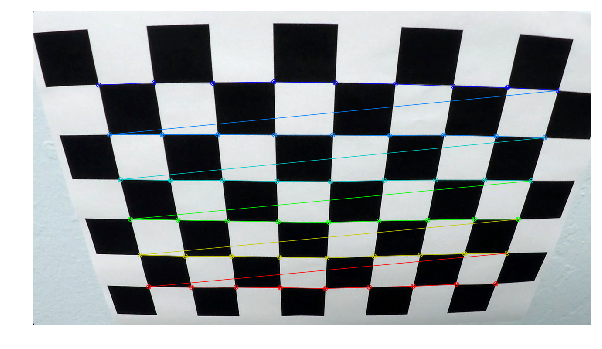

In [3]:
# test one image first  -- and find the imagesize 
img = cv2.imread("./repo/camera_cal/calibration2.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray,(x,y))


image_size = (img.shape[1], img.shape[0])     # this parameter is reusable later all the time since same camera should have same resolution


if ret == True:
#     objpoints.append(objp)
#     imgpoints.append(corners)
    cv2.drawChessboardCorners(img, (x,y), corners, ret)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
else:
    print("Failed to find corners")  # note some of the images may fail to find corners

In [4]:
# read the images of the chess board
images = glob.glob("./repo/camera_cal/calibration*.jpg")
total_successed = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        print("Find corners on file ["+ fname[-16:] + "]"+ " : Success")
        total_successed += 1
    else:
        print("Find corners on file ["+ fname[-16:] + "]"+ " : Failed")
print("Valided image: %d" % total_successed)

# find the matrix now!
print("\ncalculating the distortion matrix now")
tic = time.time()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)
toc = time.time()
print("Distortion matrix solved! Time:%d second" % (toc-tic))


Find corners on file [calibration1.jpg] : Failed
Find corners on file [alibration10.jpg] : Success
Find corners on file [alibration11.jpg] : Success
Find corners on file [alibration12.jpg] : Success
Find corners on file [alibration13.jpg] : Success
Find corners on file [alibration14.jpg] : Success
Find corners on file [alibration15.jpg] : Success
Find corners on file [alibration16.jpg] : Success
Find corners on file [alibration17.jpg] : Success
Find corners on file [alibration18.jpg] : Success
Find corners on file [alibration19.jpg] : Success
Find corners on file [calibration2.jpg] : Success
Find corners on file [alibration20.jpg] : Success
Find corners on file [calibration3.jpg] : Success
Find corners on file [calibration4.jpg] : Failed
Find corners on file [calibration5.jpg] : Failed
Find corners on file [calibration6.jpg] : Success
Find corners on file [calibration7.jpg] : Success
Find corners on file [calibration8.jpg] : Success
Find corners on file [calibration9.jpg] : Success
Val

Define the undistort function and test some images.

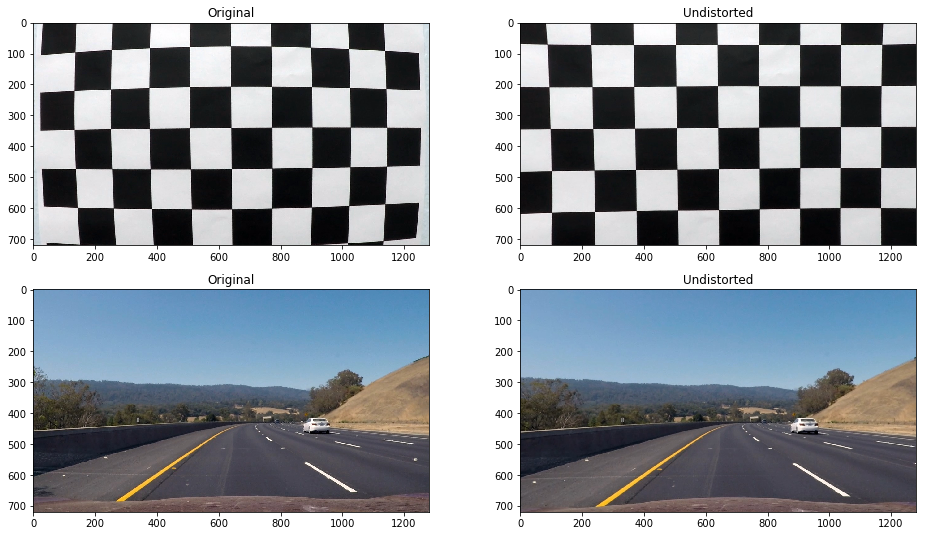

In [5]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread("./repo/camera_cal/calibration1.jpg")
plt.figure(figsize=(16, 9))
# test  on a chessboard
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted")
# test on a driving image
img = cv2.imread('./repo/test_images/test3.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted")


### 2. The camera undistortion seems to work fine, now we start finding the pipe lines

Perspective Transform

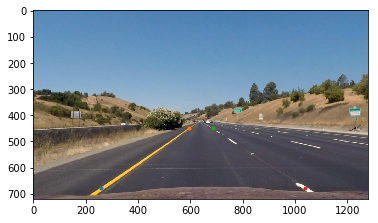

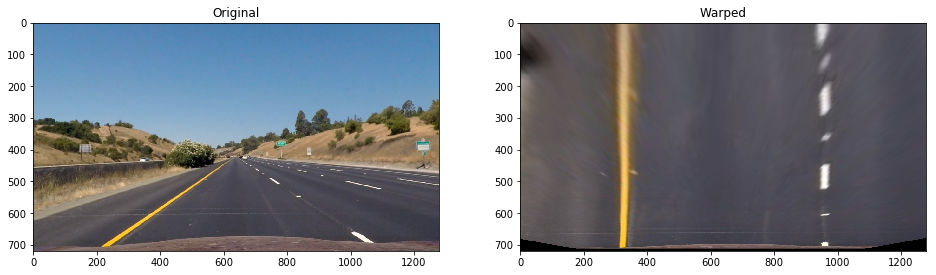

In [6]:
# note I used the a straight_line image to get the tranform matrix here
img = cv2.cvtColor(undistort(cv2.imread('./repo/test_images/straight_lines1.jpg')), cv2.COLOR_BGR2RGB)
# Manually pick 4 points on the image

plt.imshow(img)
plt.plot(260,680,".")  # bottom left
plt.plot(595,450,".") # top left
plt.plot(685,450,".") # top right
plt.plot(1040,680,".") #bottom right

src = np.float32([[260, 680], [595, 450], [685, 450], [1040, 680]])
dst = np.float32([[320, 700], [320, 0], [960, 0], [960, 700]])
Minv = Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)
def warp(img):  # this code is from the lecture video but we have to pick our own points to do the tranform
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    return warped

warped_img = warp(img)
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.subplot(2, 2, 2)
plt.imshow(warped_img)
plt.title("Warped")

Define the throshhold functions and combine them.

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        orientx, orienty = 1,0
    else:
        orientx, orienty = 0,1
    sobel = cv2.Sobel(gray, cv2.CV_64F, orientx, orienty)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sxbinary, cmap='gray')        
    # 6) Return this mask as your binary_output image
    return sxbinary


def mag_thresh(img, sobel_kernel=5, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # abs_sobelx = np.abs(sobelx)
    # abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# HLS thresholds
def threshold(image):
    """
    Take an RGB image and return a gray image with threshold mask on white and yellow
    """
    # convert to HLS 
    img = np.copy(image)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # pick the white and yellow color 
    white0 = np.array([0,210,0], dtype=np.uint8)
    white1 = np.array([255,255,255], dtype=np.uint8)
    white = cv2.inRange(hls_img,white0, white1)
    yellow0 = np.array([18,0,100], dtype=np.uint8)
    yellow1 = np.array([30,220,255], dtype=np.uint8)
    yellow = cv2.inRange(hls_img, yellow0, yellow1) 
    
    combined = np.zeros_like(white)
    combined[((white == 255) | (yellow == 255))] = 255
    combined[(combined == 255)] = 1
    return combined

Chech how the threshold function performs

(-0.5, 1279.5, 719.5, -0.5)

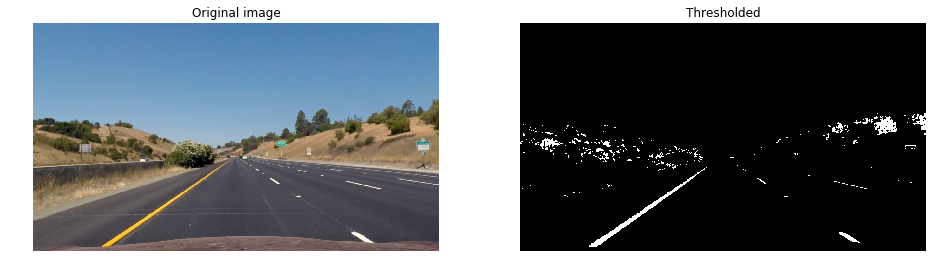

In [8]:
img = cv2.cvtColor(undistort(cv2.imread('./repo/test_images/straight_lines1.jpg')), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(threshold(img),cmap="gray")
plt.title("Thresholded")
plt.axis("off")


Now check the perspective thresholded images

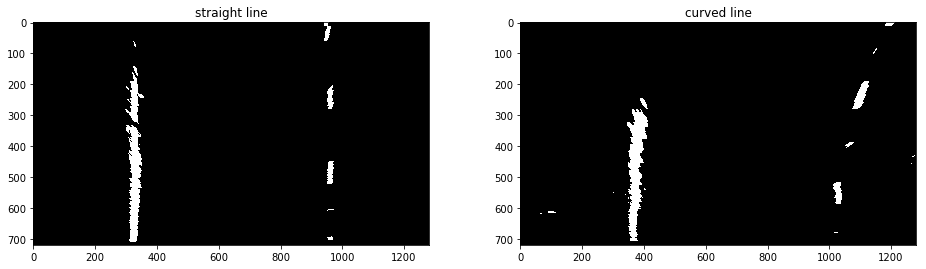

In [9]:
img1 = cv2.cvtColor(undistort(cv2.imread('./repo/test_images/straight_lines1.jpg')), cv2.COLOR_BGR2RGB)
warped_threshold1 = warp(threshold(img1))

img2 = cv2.cvtColor(undistort(cv2.imread('./repo/test_images/test4.jpg')), cv2.COLOR_BGR2RGB)
warped_threshold2 = warp(threshold(img2))

plt.figure(figsize=(16,9))
plt.subplot(2,2,1)
plt.title("straight line")
plt.imshow(warped_threshold1, "gray")


warped_threshold2 = warp(threshold(img2))
plt.subplot(2,2,2)
plt.imshow(warped_threshold2, "gray")
plt.title("curved line")

### 3. The warped/tranform and threshold functions work fine, time to start line detection.

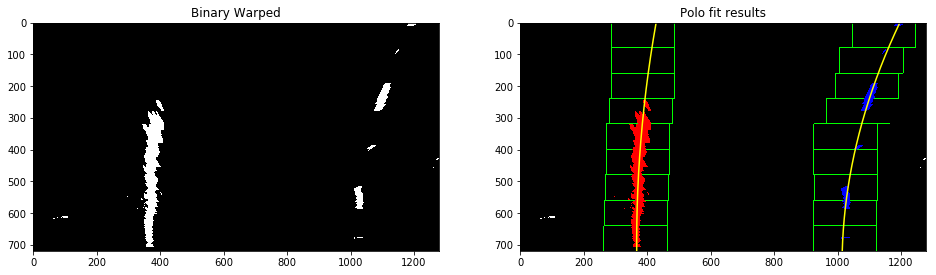

In [10]:
img = cv2.cvtColor(undistort(cv2.imread('./repo/test_images/test4.jpg')), cv2.COLOR_BGR2RGB)
binary_warped = warp(threshold(img))


# code below are from the lecture. 
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



#####
# Visualization


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title('Polo fit results')

### 4. Now let's calculate the curvature

In [11]:
ym_per_pix = 25/720 # Since in perspective I didn't use the whole line, I use 25m instead of 30m here
xm_per_pix = 3.7/640 # meters per pixel in x dimension


# y1 = (2*left_fit[0]*720 + left_fit[1])*xm_per_pix/ym_per_pix
# y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + (2*left_fit[0]*720 + left_fit[1])*xm_per_pix/ym_per_pix**2)**(1.5))\
                /np.absolute(2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix))
print("Radius of Curvature: %.0fm" % curvature)

Radius of Curvature: 858m


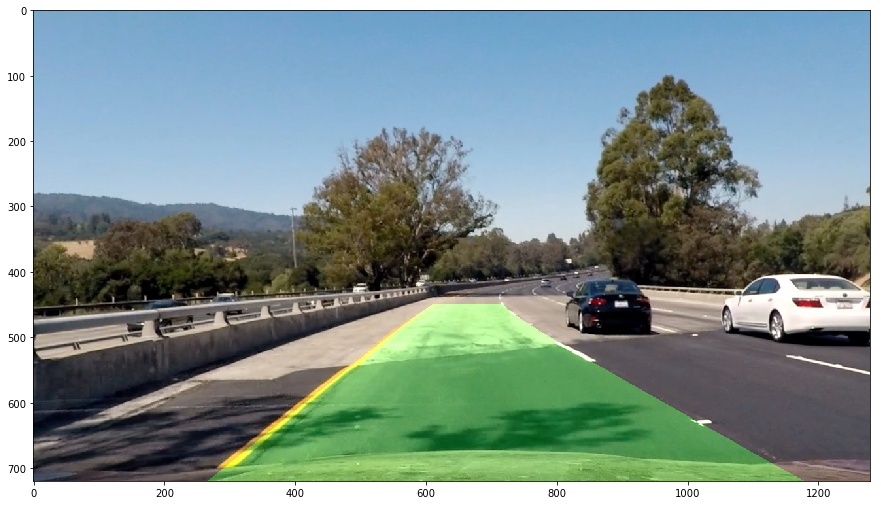

In [12]:
# add lines and inverse back to the original image
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.figure(figsize=(15,15))
plt.imshow(result)


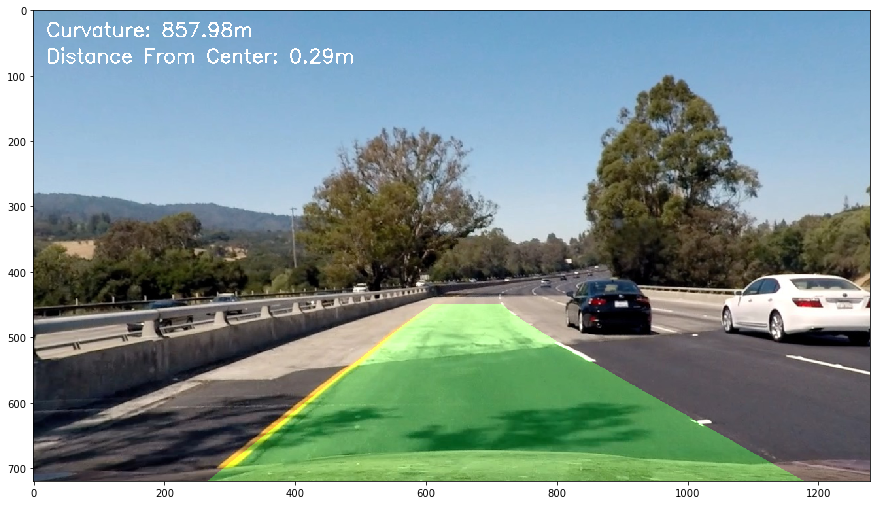

In [13]:
# Works good, now adding position information
cv2.putText(result,'Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
x_left_pix = left_fit[0]*(720**2) + left_fit[1]*720 + left_fit[2]
x_right_pix = right_fit[0]*(720**2) + right_fit[1]*720 + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - 640) * xm_per_pix
cv2.putText(result,'Distance From Center: %.2fm ' % (np.absolute(position_from_center)),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.figure(figsize=(15,15))
plt.imshow(result)

### 5.Video output

D:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


True

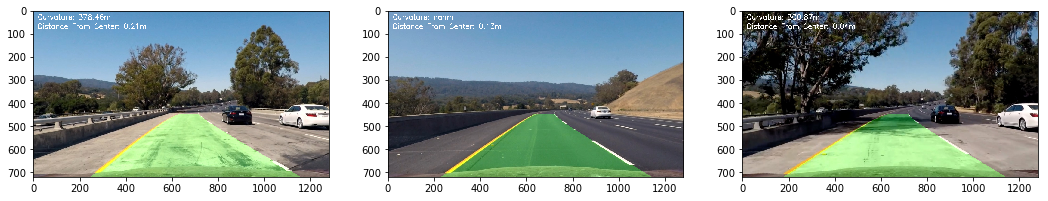

In [14]:
# first combine all the function defined before to generate a new function
# now rewrite the code above into a function
# Most code above can be deleted,but I didn't do it 
# since I can show how I analyze and implement the algorithms


def find_line(img):
    """
    Para: 
        img: an distorted BGR image
    Return: 
        result: a BGR image with the line and position info displayed
    """
    
    img= cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB)
    binary_warped = warp(threshold(img))
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    

#     # Fit a second order polynomial to each
    if lefty.size==0 or righty.size==0:
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Now we have the polonomial that fits the lines, so we can calculate the curvature
    
    ym_per_pix = 25/720 # Since the perpective didn't use the whole line, I use 25m instead of 30m here
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    curvature = ((1 + (2*left_fit[0]*720 + left_fit[1])*xm_per_pix/ym_per_pix**2)**(1.5))\
                /np.absolute(2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix))
    
    # Drawing lines and display the position infomation
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # display position info
    cv2.putText(result,'Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    x_left_pix = left_fit[0]*(720**2) + left_fit[1]*720 + left_fit[2]
    x_right_pix = right_fit[0]*(720**2) + right_fit[1]*720 + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - 640) * xm_per_pix
    cv2.putText(result,'Distance From Center: %.2fm ' % (np.absolute(position_from_center)),
                (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return cv2.cvtColor(result, cv2.COLOR_RGB2BGR)



img_test1 = cv2.imread('./repo/test_images/test1.jpg')
img_test3 = cv2.imread('./repo/test_images/test3.jpg')
img_test5 = cv2.imread('./repo/test_images/test5.jpg')
result1 = find_line(img_test1)
result3 = find_line(img_test3)
result5 = find_line(img_test5)

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(result3, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(result5, cv2.COLOR_BGR2RGB))

cv2.imwrite("./repo/output_images/test1.jpg", result1)
cv2.imwrite("./repo/output_images/test1.jpg", result3)
cv2.imwrite("./repo/output_images/test1.jpg", result5)
    

In [15]:
# # Now video!
# from moviepy.editor import VideoFileClip

# clip1 = VideoFileClip("project_video.mp4")
# process = clip1.fl_image(find_line)
# %time process.write_videofile("./repo/output_videos/project_output.mp4", audio=False)
import sys, time

def analyze_video(video_src,video_save):
    """
    Parameters:
        video_src: a string that represent the address of the video
        video_save: a string that where you want to save the processed video
    """
    cap  = cv2.VideoCapture(video_src)
    success = True
    fourcc = cv2.VideoWriter_fourcc('D', 'I','V','X')
    videoWriter = cv2.VideoWriter(video_save,fourcc,25,(1280,720))
    frame_n = 0
    all_frames = []

    tic = time.time()

    print("Reading video...")
    while(success):
            success, frame = cap.read()
            all_frames.append(frame)
            frame_n+=1
    print("Total frames in this video: ", frame_n)
    for i in range(len(all_frames)-1):
        sys.stdout.write('Processing Video {0}/{1}\r'.format(i, frame_n))
        sys.stdout.flush()
        videoWriter.write(find_line(all_frames[i]))


    print("writing frames %d/%d, Done!" % (frame_n, frame_n) )
    toc = time.time()
    print("total time spent:", toc-tic)
    cap.release()
    videoWriter.release()
    


src = "./repo/project_video.mp4"
target = "./repo/output_videos/project_output.mp4"
analyze_video(src, target)


Reading video...
Total frames in this video:  1250


D:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


writing frames 1250/1250, Done!
total time spent: 112.56247901916504


### Discuss
I don't know what's wrong with the VideoFileClip, I kept getting weird result videos, so I decide to use opencv videoWriter() to produce the video, which seems even faster. However, I will get an error when I process a video's last frame, and the code runs fine if I don't process the last frame. 
I should have tried the challenging problems by fitting a higher order polynomial. But it was Chinese New Year the last month, and I went back to China from U.S. on Christmas, I was kind of behind so I would rather pass this project's least requirement first to make sure I can finish term1 in time. I will go back to rewrite the code later.